In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import MinMaxScaler

In [5]:
file_beef = Path("Beef84_22.csv")
file_cpi = Path("CPI_Average.csv")

In [6]:

beef_file = pd.read_csv(file_beef)
CPI_file = pd.read_csv(file_cpi)

In [7]:
df_beef = pd.DataFrame(beef_file)
df_beef.set_index(pd.to_datetime(df_beef['Year'], infer_datetime_format=True), inplace=True)
df_beef = df_beef.drop(columns=['Year'], axis=1)
df_beef = df_beef.pct_change()

df_cpi = pd.DataFrame(CPI_file)
df_cpi.set_index(pd.to_datetime(df_cpi['Year'], infer_datetime_format=True), inplace=True) 
df_cpi = df_cpi.drop(columns=['Year'], axis=1)
df_cpi  = df_cpi.pct_change()


In [8]:
df_inflation = pd.concat([df_beef, df_cpi], axis="columns", join = "inner")

In [9]:
def fill_missing(values):
    one_month = 30
    for row in range(df_inflation.shape[0]):
        for col in range(df_inflation.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_month,col]
df_inflation = df_inflation.astype('float32')
fill_missing(df_inflation.values)
df_inflation.isnull().sum()

Beef    0
CPI     0
dtype: int64

In [10]:
def window_data(df_inflation, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df_inflation) - window):
        features = df_inflation.iloc[i : (i + window), feature_col_number]
        target = df_inflation.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [11]:
 # Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 1
target_column = 1

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(df_inflation, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:10]} \n")
print (f"y sample values:\n{y[:10]}")


X sample values:
[[-0.00090977  0.00490677  0.00195312  0.00487329  0.0029098   0.00290135
   0.00385728  0.00384246  0.00478469  0.00285714  0.          0.
   0.00189934  0.00473934  0.00377358  0.00469925  0.00374181  0.0027959
   0.00185874  0.00185529  0.00277778  0.00369344  0.00275989  0.00275229
   0.00274474 -0.00273723 -0.00457457 -0.00183824  0.00276243  0.00550964]
 [ 0.00490677  0.00195312  0.00487329  0.0029098   0.00290135  0.00385728
   0.00384246  0.00478469  0.00285714  0.          0.          0.00189934
   0.00473934  0.00377358  0.00469925  0.00374181  0.0027959   0.00185874
   0.00185529  0.00277778  0.00369344  0.00275989  0.00275229  0.00274474
  -0.00273723 -0.00457457 -0.00183824  0.00276243  0.00550964  0.        ]
 [ 0.00195312  0.00487329  0.0029098   0.00290135  0.00385728  0.00384246
   0.00478469  0.00285714  0.          0.          0.00189934  0.00473934
   0.00377358  0.00469925  0.00374181  0.0027959   0.00185874  0.00185529
   0.00277778  0.00369344  0

In [12]:
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [14]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.581494  ]
  [0.7668944 ]
  [0.67274785]
  [0.76582736]
  [0.70324147]
  [0.70297235]
  [0.7334422 ]
  [0.73296976]
  [0.76300305]
  [0.7015631 ]
  [0.6104926 ]
  [0.6104926 ]
  [0.6710333 ]
  [0.76155746]
  [0.73077446]
  [0.76027966]
  [0.7297618 ]
  [0.699611  ]
  [0.66973925]
  [0.66962934]
  [0.6990334 ]
  [0.72822   ]
  [0.6984632 ]
  [0.6982211 ]
  [0.6979803 ]
  [0.5232444 ]
  [0.46467972]
  [0.55189943]
  [0.6985442 ]
  [0.78611076]]

 [[0.7668944 ]
  [0.67274785]
  [0.76582736]
  [0.70324147]
  [0.70297235]
  [0.7334422 ]
  [0.73296976]
  [0.76300305]
  [0.7015631 ]
  [0.6104926 ]
  [0.6104926 ]
  [0.6710333 ]
  [0.76155746]
  [0.73077446]
  [0.76027966]
  [0.7297618 ]
  [0.699611  ]
  [0.66973925]
  [0.66962934]
  [0.6990334 ]
  [0.72822   ]
  [0.6984632 ]
  [0.6982211 ]
  [0.6979803 ]
  [0.5232444 ]
  [0.46467972]
  [0.55189943]
  [0.6985442 ]
  [0.78611076]
  [0.6104926 ]]

 [[0.67274785]
  [0.76582736]
  [0.70324147]
  [0.70297235]
  [0.7334422 

In [15]:
model = Sequential()

# Initial model setup
number_units = 800
#hidden_units = 17 
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))


# Output layer
model.add(Dense(1))

In [16]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 800)           2566400   
                                                                 
 dropout (Dropout)           (None, 30, 800)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 800)           5123200   
                                                                 
 dropout_1 (Dropout)         (None, 30, 800)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 800)           5123200   
                                                                 
 dropout_2 (Dropout)         (None, 30, 800)           0         
                                                                 
 lstm_3 (LSTM)               (None, 800)               5

In [18]:
model.fit(X_train, y_train, epochs=500, shuffle=False, batch_size=100, verbose=1)

Epoch 1/500
4/4 [==============================] - 7s 59ms/step - loss: 0.5501
Epoch 2/500
4/4 [==============================] - 0s 54ms/step - loss: 0.0240
Epoch 3/500
4/4 [==============================] - 0s 53ms/step - loss: 0.3116
Epoch 4/500
4/4 [==============================] - 0s 54ms/step - loss: 0.2522
Epoch 5/500
4/4 [==============================] - 0s 54ms/step - loss: 0.1162
Epoch 6/500
4/4 [==============================] - 0s 54ms/step - loss: 0.0387
Epoch 7/500
4/4 [==============================] - 0s 53ms/step - loss: 0.0187
Epoch 8/500
4/4 [==============================] - 0s 54ms/step - loss: 0.0303
Epoch 9/500
4/4 [==============================] - 0s 57ms/step - loss: 0.0183
Epoch 10/500
4/4 [==============================] - 0s 53ms/step - loss: 0.0161
Epoch 11/500
4/4 [==============================] - 0s 54ms/step - loss: 0.0134
Epoch 12/500
4/4 [==============================] - 0s 54ms/step - loss: 0.0122
Epoch 13/500
4/4 [==============================]

In [19]:
model.evaluate(X_test, y_test, verbose=0)

0.010878439992666245

In [20]:
predicted = model.predict(X_test)

5/5 [==============================] - 1s 19ms/step


In [21]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [22]:
# Create a DataFrame of Real and Predicted values
CPI = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df_inflation.index[-len(real_prices): ]) 

# Show the DataFrame's head
CPI.tail()

,Actual,Predicted
Year,,
2022-01-01,0.008415,0.003019
2022-02-01,0.009134,0.003866
2022-03-01,0.013351,0.004066
2022-04-01,0.005583,0.003802
2022-05-01,0.011024,0.003155


<AxesSubplot:title={'center':'Actual Vs. Predicted'}, xlabel='Year'>

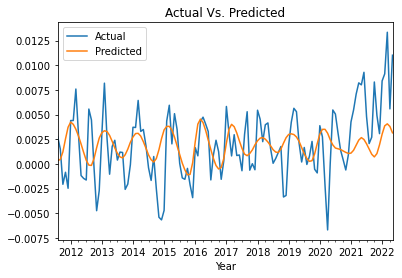

In [23]:
CPI.plot(title="Actual Vs. Predicted")

In [24]:
CPI.to_csv('beef_predict.csv')